Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [40]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
  # DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
  !pip install category_encoders==2.*
  !pip install pandas-profiling==2.*
  !pip install eli5

# If you're working locally:
# else:
#     DATA_PATH = '../data/'



In [4]:
# A UCI dataset for predicting crime rates (Unnormalized)
# https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized

# To extract a list of column names from a website describing a dataset
import re
column_names = !curl https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized
# @attribute community numeric
column_names = [ re.search('-- (\S+): ', line) for line in column_names ]
column_names = [ match.group(1) for match in column_names if match ]
column_names = column_names[2:]  # 'Creator' and 'Donor' get included from the webpage, but aren't features
# Descriptions for the column names can be found on the main website
# https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized

import pandas as pd
data_url =  'https://archive.ics.uci.edu/ml/machine-learning-databases/00211/CommViolPredUnnormalizedData.txt'
df = pd.read_csv(data_url, names = column_names, na_values=['?'])
df.head()

,communityname,state,countyCode,communityCode,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,...,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,murders,murdPerPop,rapes,rapesPerPop,robberies,robbbPerPop,assaults,assaultPerPop,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
0,BerkeleyHeightstownship,NJ,39.0,5320.0,1,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,11980,100.0,75122,89.24,1.55,70.20,23.62,1.03,18.39,79584,29711,30233,13600,5725,27101,5115.0,22838,227,1.96,5.81,9.90,48.18,2.70,64.55,14.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5,1845.9,9.63,NaN,NaN,NaN,NaN,0.0,NaN,0,0.0,0.0,0.00,1.0,8.20,4.0,32.81,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59
1,Marpletownship,PA,45.0,47616.0,1,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,23123,100.0,47917,78.99,1.11,64.11,35.50,2.75,22.85,55323,20148,20191,18137,0,20074,5250.0,12222,885,3.98,5.61,13.72,29.89,2.43,61.96,12.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.6,2186.7,3.84,NaN,NaN,NaN,NaN,0.0,NaN,0,0.0,1.0,4.25,5.0,21.26,24.0,102.05,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95
2,Tigardcity,OR,NaN,NaN,1,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,29344,100.0,35669,82.00,1.15,55.73,22.25,2.94,14.56,42112,16946,17103,16644,21606,15528,5954.0,8405,1389,4.75,2.80,9.09,30.13,4.01,69.80,15.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.6,2780.9,4.37,NaN,NaN,NaN,NaN,0.0,NaN,3,8.3,6.0,16.60,56.0,154.95,14.0,38.74,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51
3,Gloversvillecity,NY,35.0,29443.0,1,16656,2.40,1.70,97.35,0.50,0.70,12.55,25.20,12.19,17.57,0,0.0,20580,68.15,0.24,38.95,39.48,11.71,18.33,26501,10810,10909,9984,4941,3541,2451.0,4391,2831,17.23,11.05,33.68,10.81,9.86,54.74,31.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.2,3217.7,3.31,NaN,NaN,NaN,NaN,0.0,NaN,0,0.0,10.0,57.86,10.0,57.86,33.0,190.93,225.0,1301.78,716.0,4142.56,47.0,271.93,NaN,NaN,306.64,NaN
4,Bemidjicity,MN,7.0,5068.0,1,11245,2.76,0.53,89.16,1.17,0.52,24.46,40.53,28.69,12.65,0,0.0,17390,69.33,0.55,42.82,32.16,11.21,14.43,24018,8483,9009,887,4425,3352,3000.0,1328,2855,29.99,12.15,23.06,25.28,9.08,52.44,6.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.5,974.2,0.38,NaN,NaN,NaN,NaN,0.0,NaN,0,0.0,NaN,NaN,4.0,32.04,14.0,112.14,91.0,728.93,1060.0,8490.87,91.0,728.93,5.0,40.05,NaN,9988.79


In [3]:
# Get Pandas Profiling Report
from pandas_profiling import ProfileReport
profile = ProfileReport(df, minimal=True).to_notebook_iframe()
profile

Output hidden; open in https://colab.research.google.com to view.

In [6]:
df.head()

,communityname,state,countyCode,communityCode,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,...,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,murders,murdPerPop,rapes,rapesPerPop,robberies,robbbPerPop,assaults,assaultPerPop,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
0,BerkeleyHeightstownship,NJ,39.0,5320.0,1,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,11980,100.0,75122,89.24,1.55,70.20,23.62,1.03,18.39,79584,29711,30233,13600,5725,27101,5115.0,22838,227,1.96,5.81,9.90,48.18,2.70,64.55,14.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5,1845.9,9.63,NaN,NaN,NaN,NaN,0.0,NaN,0,0.0,0.0,0.00,1.0,8.20,4.0,32.81,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59
1,Marpletownship,PA,45.0,47616.0,1,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,23123,100.0,47917,78.99,1.11,64.11,35.50,2.75,22.85,55323,20148,20191,18137,0,20074,5250.0,12222,885,3.98,5.61,13.72,29.89,2.43,61.96,12.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.6,2186.7,3.84,NaN,NaN,NaN,NaN,0.0,NaN,0,0.0,1.0,4.25,5.0,21.26,24.0,102.05,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95
2,Tigardcity,OR,NaN,NaN,1,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,29344,100.0,35669,82.00,1.15,55.73,22.25,2.94,14.56,42112,16946,17103,16644,21606,15528,5954.0,8405,1389,4.75,2.80,9.09,30.13,4.01,69.80,15.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.6,2780.9,4.37,NaN,NaN,NaN,NaN,0.0,NaN,3,8.3,6.0,16.60,56.0,154.95,14.0,38.74,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51
3,Gloversvillecity,NY,35.0,29443.0,1,16656,2.40,1.70,97.35,0.50,0.70,12.55,25.20,12.19,17.57,0,0.0,20580,68.15,0.24,38.95,39.48,11.71,18.33,26501,10810,10909,9984,4941,3541,2451.0,4391,2831,17.23,11.05,33.68,10.81,9.86,54.74,31.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.2,3217.7,3.31,NaN,NaN,NaN,NaN,0.0,NaN,0,0.0,10.0,57.86,10.0,57.86,33.0,190.93,225.0,1301.78,716.0,4142.56,47.0,271.93,NaN,NaN,306.64,NaN
4,Bemidjicity,MN,7.0,5068.0,1,11245,2.76,0.53,89.16,1.17,0.52,24.46,40.53,28.69,12.65,0,0.0,17390,69.33,0.55,42.82,32.16,11.21,14.43,24018,8483,9009,887,4425,3352,3000.0,1328,2855,29.99,12.15,23.06,25.28,9.08,52.44,6.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.5,974.2,0.38,NaN,NaN,NaN,NaN,0.0,NaN,0,0.0,NaN,NaN,4.0,32.04,14.0,112.14,91.0,728.93,1060.0,8490.87,91.0,728.93,5.0,40.05,NaN,9988.79


In [36]:
# Feature Engineering Time!

# Then remove rows where my targets are null
# (turns out models don't like comparing their prediction to null)
good_rows = df[~(df.ViolentCrimesPerPop.isna() | df.nonViolPerPop.isna())]

# The final columns are all various crime rates
features = good_rows[column_names[:129]]
unusable_columns = ['communityname', 'countyCode', 'communityCode', 'fold']
features.drop(columns=unusable_columns, errors='ignore', inplace=True)

# Remove the lemas columns. They 22 are columns on the size and structure of a police department
# but there are only observations for 343 communities, and 1872 missing observations.
lema_columns = [col for col in df.columns if df[col].isna().sum() == 1872]
features.drop(columns=lema_columns, errors='ignore', inplace=True)

# Create a smaller DataFrame (343,22) of just the lemas data
# May use for making better predicitons for these communities
lemas = df[lema_columns]
lemas = lemas[~df.LemasSwornFT.isna()]

# Lets set our targets
y1 = good_rows['ViolentCrimesPerPop']
y2 = good_rows['nonViolPerPop']

# If I want to expand to a true multiclass regression problem
targets = good_rows[column_names[129:]]


print('Features', features.shape)
print('Lemas', lemas.shape)
print('Targets', targets.shape)
print('ViolentCrimesPerPop', y1.shape)
print('nonViolPerPop', y2.shape)

Features (1902, 103)
Lemas (343, 22)
Targets (1902, 18)
ViolentCrimesPerPop (1902,)
nonViolPerPop (1902,)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [4]:
# Features
print('Features', features.shape)
display(features.head())

# Lemas
print('\nLemas', lemas.shape)
display(lemas.head())

# Target
print('\nTargets', targets.shape)
display(targets.head())

NameError: ignored

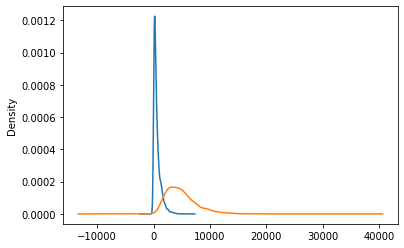

In [23]:
# What's the distributions of my targets?
y1.plot.density()
y2.plot.density()

In [ ]:
y1.log

In [3]:
# Import the train_test_split utility
from sklearn.model_selection import train_test_split

# Create the "remaining" and test datasets
X_train, X_test, y_train, y_test = train_test_split(
    features, y1, test_size=0.2, random_state=42)

NameError: ignored

In [1]:
# I iteratively ran this over and over at n_iter=15, and did the following steps
# 1. Take the model parameters from the best 3 models from search.cv_results_
# 2. Adjust param_distributions with the min and max of the top 3 models
# 3. Run again and repeat until the parameters are in a narrow range.

from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

pipeline = make_pipeline(
    OrdinalEncoder(cols=['state']),
    SimpleImputer(),
    RandomForestRegressor(),
    )
# pipeline = make_pipeline(
#     OrdinalEncoder(),  # cols=['state']
#     # SimpleImputer(strategy='median'), 
#     XGBClassifier(
#         n_estimators=100,
#         random_state=42,
#         n_jobs=-1,
#         )
# )
# _, n_features = X_train_val.shape
# depths = np.linspace(2, 2*n_features,dtype='int')

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'], 

    # 'xgbclassifier__n_estimators': randint(2, 100),
    'randomforestregressor__n_estimators': randint(2, 100),
    'randomforestregressor__max_depth': randint(2, 80),
    # 'randomforestclassifier__max_features': uniform(0, 1),
    # 'randomforestclassifier__min_samples_split': randint(2, 500),
    # 'randomforestclassifier__min_samples_leaf': randint(1, 500),
    # 'randomforestclassifier__bootstrap': [True, False],
    # 'randomforestclassifier__ccp_alpha': uniform(0, 1-0),
    # 'randomforestclassifier__class_weight': [None],
    # 'randomforestclassifier__criterion': ['gini', 'entropy'],
    # 'randomforestclassifier__max_leaf_nodes': [None],
    # 'randomforestclassifier__max_samples': [None],
    # 'randomforestclassifier__min_impurity_decrease': [0.0],
    # 'randomforestclassifier__min_impurity_split': [True, False],
    # 'randomforestclassifier__min_weight_fraction_leaf': [0.0],
    # 'randomforestclassifier__oob_score': [True, False],
    # 'randomforestclassifier__verbose': [0],
    # 'randomforestclassifier__warm_start': [True, False],
}
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
# https://contrib.scikit-learn.org/category_encoders/targetencoder.html
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions = param_distributions, 
    n_iter=20, 
    cv=5,
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

search.fit(X_train, y_train);

best_model = search.best_estimator_
print('Train/Val Accuracy', best_model.score(X_train, y_train))
print(search.best_params_)

ModuleNotFoundError: ignored

In [49]:
y1[:10]

0       41.02
1      127.56
2      218.59
5      442.95
6      226.63
7      439.73
8      115.31
9     1544.24
10     722.02
11    2605.96
Name: ViolentCrimesPerPop, dtype: float64

In [43]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    best_model,
    scoring = 'neg_mean_absolute_error',
    n_iter=5,
    random_state = 42
)
encoder = OrdinalEncoder(cols=['state'])
X_encoded = encoder.fit_transform(X_train)
permuter.fit(X_encoded, y_train)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


PermutationImportance(cv='prefit',
                      estimator=Pipeline(memory=None,
                                         steps=[('ordinalencoder',
                                                 OrdinalEncoder(cols=['state'],
                                                                drop_invariant=False,
                                                                handle_missing='value',
                                                                handle_unknown='value',
                                                                mapping=[{'col': 'state',
                                                                          'data_type': dtype('O'),
                                                                          'mapping': NH      1
OH      2
WY      3
NJ      4
MO      5
WI      6
OK      7
WV      8
SD      9
CA     10
CO     11
SC     12
TX     13
MA     14
FL     15
KY     16
AL     17
GA     18
IN     19
CT     20
ID     21
PA     22
VA     2

In [47]:
best_model.score(X_test, y_test)

0.6095720448242308

In [46]:
eli5.show_weights(
    permuter,
    top = None, # no limit
    feature_names = X_train.columns.to_list() # must be a list
)

Weight,Feature
141.7156 ± 7.0653,PctKidsBornNeverMar
121.0315 ± 5.9600,PctKids2Par
48.1770 ± 3.7953,racePctWhite
20.0773 ± 0.4868,NumKidsBornNeverMar
16.4760 ± 1.3611,racepctblack
10.6793 ± 0.7484,HousVacant
9.9078 ± 1.6986,racePctHisp
9.5926 ± 0.5620,PctFam2Par
9.2254 ± 1.1017,NumStreet
9.1382 ± 1.0899,PctPersDenseHous
